# Stack Exchange Analysis
Stack Exchange is a Q & A platform extending across many fields, that uses an up-vote/down-vote system. They've tasked us with analyzing trends and looking for ways to improve UX for new users. Stack Exchange is also considering adding data science curriculum and looking for data based recommendations. Our primary tool will be Stack Exchange's [Data Explorer](https://data.stackexchange.com/datascience/query/new), an SQL based database used to access post/user history. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import datetime
import seaborn as sns
from statistics import mean, median
%matplotlib inline

# Load query results for Stack Exchange posts (SQL used below)
'''
SELECT Id,
       PostTypeId,
       CreationDate,
       Score,
       ViewCount,
       Body,
       Title,
       Tags,
       AnswerCount,
       CommentCount,
       AcceptedAnswerId,
       ParentId
FROM posts
WHERE CreationDate > '01/01/2019'
AND
PostTypeID <= 2
'''
posts = pd.read_csv('QueryResultsPosts.csv', parse_dates=['CreationDate'])
questions = posts[posts['PostTypeId'] == 1].reset_index(drop=True)

In our first database query, we specify that we want to retrieve all posts that are questions for 2019 and beyond. We want a large sample of reasonably current trends.

In [2]:
# Inspect posts
print(questions.shape)
print(questions.isna().sum())
print(questions.dtypes)
print(questions.head())

(12948, 13)
Id                      0
OwnerUserId            61
PostTypeId              0
CreationDate            0
Score                   0
ViewCount               0
Body                    0
Title                   0
Tags                    0
AnswerCount             0
CommentCount            0
AcceptedAnswerId     9606
ParentId            12948
dtype: int64
Id                           int64
OwnerUserId                float64
PostTypeId                   int64
CreationDate        datetime64[ns]
Score                        int64
ViewCount                  float64
Body                        object
Title                       object
Tags                        object
AnswerCount                float64
CommentCount                 int64
AcceptedAnswerId           float64
ParentId                   float64
dtype: object
      Id  OwnerUserId  PostTypeId        CreationDate  Score  ViewCount  \
0  68406      65019.0           1 2020-02-20 12:52:58      0       22.0   
1  68407      6326

Fortunately, the data is in good shape. We can leave the NA values for now. First, we will look into tags to see if we can determine which tags are the most popular.

In [3]:
# Remove < > characters, trim white space, join into one string to prep for wordcloud
text = questions['Tags'].str.replace('[<>]', " ").str.strip().str.replace('  ', ',')
text = ' '.join(text)

(-0.5, 3999.5, 2499.5, -0.5)

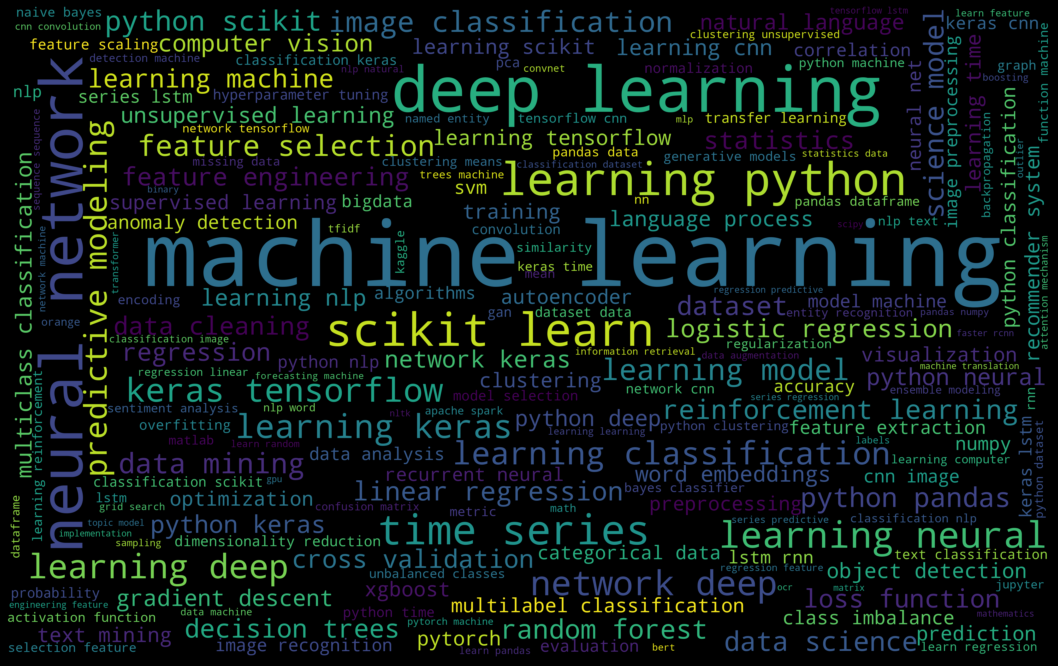

In [4]:
# Create wordcloud
wordcloud = WordCloud(
    width = 4000,
    height = 2500,
    background_color = 'black').generate(text)
fig = plt.figure(
    figsize = (20, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

The wordcloud reveals that 'Machine Learning' is the most used tag. It also appears that a lot of machine learning relevant tags are popular, particularly those associated with deep learning. We can inspect tags to get a count of the most used tags. We can go a step further and multiply that count by the view count for each time it is used to get an idea of not only the volume, but also of the visibility for users.

In [5]:
# Transform tags
# Remove < > characters, trim white space, separate by commas, convert to list
questions['Tags'] = questions['Tags'].str.replace('[<>]', " ").str.strip().str.replace('  ', ',')
questions['Tags'] = questions['Tags'].str.split(",")

In [6]:
# Get count of occurences for each tag multiplied by view count    
def count_tags(df, view_multiplier=False):
    '''
    If view_multiplier = False, function counts the occurences of each tag in df.
    if view_multiplier = True, funtion multiplies that count times number of views for question that the tag occurred in.
    '''
    tag_count = {}
    for i in range(len(df)):
        for tag in df.loc[i, 'Tags']:
          
            if tag in tag_count:
                if view_multiplier:
                    tag_count[tag] += df.loc[i, 'ViewCount']
                else:
                    tag_count[tag] += 1
            else:
                if view_multiplier:
                    tag_count[tag]  = df.loc[i, 'ViewCount']
                else:
                    tag_count[tag] = 1

    return tag_count

tag_view_count = count_tags(questions, view_multiplier=True)


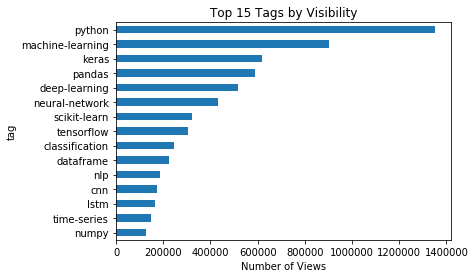

In [7]:
# Find the top 15 tags and plot
top_15_tags = sorted(tag_view_count.items(), key=lambda x: x[1])[-15:]
tags_df = pd.DataFrame(top_15_tags, columns = ['tag', 'count'])
tags_df.plot(kind='barh', x='tag',y = 'count',legend=None)
plt.title("Top 15 Tags by Visibility")
plt.xlabel('Number of Views')
plt.show()

Unsurprisingly, python and machine-learning top the charts. There also appear to be several deep learning related topics. We could investigate these tags to see if this is a growing trend.

In [8]:
# Compile list of deep learning related tags
deep_learning_tags = ['deep-learning', 'neural-network', 'keras', 'tensorflow', 'cnn', 'lstm', 'convnet','rnn', 'pytorch', 'autoencoder', 'gan', 'object-detection', 'neural-net', 'image-recognition',' image-classification']

# Create IsDeepLearning col
questions['IsDeepLearning'] = 0
deep_learning_tags = ['machine-learning', 'deep-learning', 'neural-network', 'keras', 'tensorflow', 'classification', 'scikit-learn']
def IsDeepLearning(col):
    for tag in deep_learning_tags:
        if tag in col:
            return 1
        else:
            return 0

questions['IsDeepLearning'] = questions['Tags'].apply(IsDeepLearning)

In [9]:
# Isolate all of the deep learning related questions
deep_learning_only = questions[questions['IsDeepLearning'] == 1]

# See what percentage of all questions are deep learning related
questions_by_month = questions.groupby(['IsDeepLearning', questions['CreationDate'].dt.year, questions['CreationDate'].dt.month]).size()
percent_of_dl_Qs = questions_by_month[1].values / (questions_by_month[0].values + questions_by_month[1].values) * 100 

# Gather results in dataframe
years = questions_by_month.index.get_level_values(1)[0:len(percent_of_dl_Qs)]
months = questions_by_month.index.get_level_values(2)[0:len(percent_of_dl_Qs)]

# Convert Date 
date = years.astype(str) + '-' + months.astype(str)
dl_count = pd.DataFrame({'Date': date, 
                         'DL_questions': percent_of_dl_Qs})

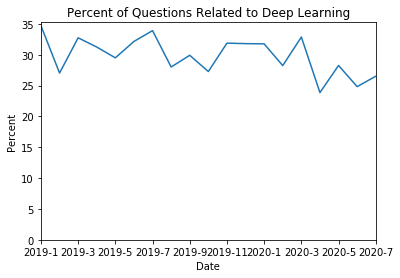

In [10]:
# Plot deep learning results
dl_count.plot('Date', 'DL_questions', legend=None)

plt.ylabel("Percent")
plt.title("Percent of Questions Related to Deep Learning")
plt.ylim(bottom = 0)
plt.show()

Deep learning tags are trending downward, although at a modest rate. One possibility is that as the data science field grows, more and more newcomers are flocking to Stack Exchange, users who are more likely to ask simple questions rather than advanced deep learning questions. Another possibility is that the buzz surrounding deep learning is fading a bit. Still, these tags have representation in over 25% of questions which is something Stack Exchange will want to capitalize on if they expand into curriculum. It will be important to monitor the trends to make sure deep learning topics don't exhibit a sharp decline.

Do questions of different lengths get different results? We can judge people's willingness to respond by the number of answers a question receives.

In [11]:
# Get number of characters for questions only
questions['BodyLength'] = questions['Body'].apply(len)
# Use qcut to divide data into 4 intervals based on frequency
questions['BodyQuartile'] = pd.qcut(questions['BodyLength'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

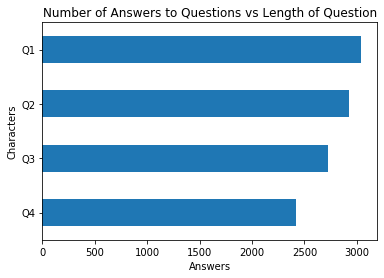

In [12]:
# Group by quartile and plot num answers
answered_questions = questions.groupby('BodyQuartile')['AnswerCount'].sum()
answered_questions.plot.barh()
plt.title("Number of Answers to Questions vs Length of Question")
plt.xlabel("Answers")
plt.ylabel("Characters")
plt.gca().invert_yaxis()

Keeping questions short and sweet (Q1) is correlated with getting more responses, however, we can't overlook the possibility that more responses include responses such as "You didn't include enough info in your short question." Let's investigate further. Did these short questions get higher ratings?

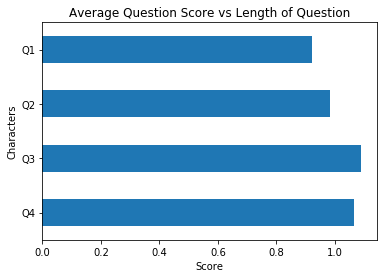

In [13]:
# Group by quartile and plot scores
question_scores = questions.groupby('BodyQuartile')['Score'].mean()    
question_scores.plot.barh()
plt.title("Average Question Score vs Length of Question")
plt.xlabel("Score")
plt.ylabel("Characters")
plt.gca().invert_yaxis()

We now see the opposite results! It appears that shorter questions get more answers, but longer questions are better received (higher average score). Our hypothesis may be correct that short questions require more follow up questions from other users to get more clarification. This adds to the answer count but it doesn't necessarily make for a better question. 

Diving deeper, perhaps the majority of short questions are linked to new users. New users may be more prone to produce lower rated questions due to inexperience. We can isolate by the user's history to see if the current results still hold or if experience plays a large role.

In [14]:
# Load query results for Stack Exchange users (SQL below)
'''SELECT Id,
       Reputation,
       CreationDate,
       Views,
       UpVotes,
       DownVotes
FROM Users
'''
users = pd.read_csv('QueryResultsUsers.csv', parse_dates=['CreationDate'])

count    50000.00000
mean        52.06318
std        193.66687
min          1.00000
25%          1.00000
50%          1.00000
75%        101.00000
max      23068.00000
Name: Reputation, dtype: float64


(array([31349.,   655., 16396.,   643.,   233.,   138.,   105.,    78.,
           55.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450]),
 <a list of 9 Patch objects>)

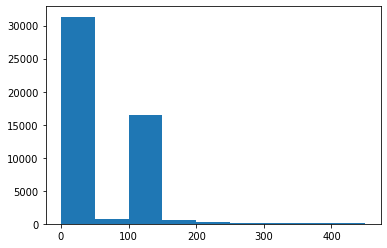

In [15]:
# Get reputation stats for users
print(users['Reputation'].describe())
plt.hist(users['Reputation'], bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450])

We've decided to use Reputation as the metric to determine if a user is a rookie or not. This isn't perfect, it's possible that the user was a rookie when he made a post in question, and grew his reputation after, but overall this should be a good metric to use. Reputation ranges from 1 to 23,068, but the majority of users have a reputation of 1, which we will use to indicate a rookie poster.

In [16]:
# Add IsRookie column
users['IsRookie'] = (users['Reputation'] == 1).astype(int)
users = users.rename(columns={'Id': 'UserId'})

# Merge with questions df
questions = questions.merge(right = users[['UserId', 'IsRookie']], how='left', left_on='OwnerUserId', right_on='UserId')

# Not all posts have a user match from the user df, so we will drop those rows
questions = questions.dropna(axis=0, subset = ['IsRookie'])

(47.999, 510.0]      1916
(1468.5, 30384.0]    1909
(510.0, 858.0]       1907
(858.0, 1468.5]      1902
Name: BodyLength, dtype: int64 



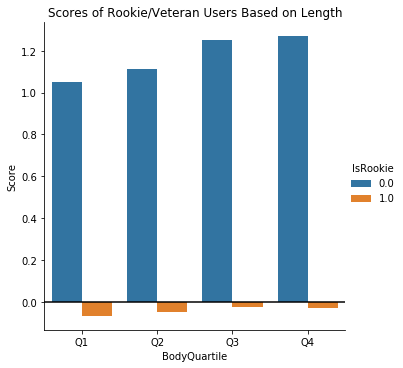

In [17]:
# Redo previous plots but with Rookie status added
question_scores = questions.groupby(['IsRookie', 'BodyQuartile'], as_index=False)['Score'].mean()    

# Plot
sns.catplot('BodyQuartile', 'Score', hue='IsRookie', data=question_scores, kind='bar')
plt.title("Scores of Rookie/Veteran Users Based on Length")
plt.axhline(y=0, color='k')
print(pd.qcut(questions['BodyLength'], 4).value_counts(), "\n")

The obvious takeaway is that rookie users' questions rate very poorly! After removing rookie users from the equation, shorter questions are still less well received than longer questions. It is recommended to use at least 850 characters (bottom end of Q3) when posting a question.
We'd now like to investigate what question topics have been left without an accepted answer. 

Percentage of All Questions With Approved Answer: 25.5


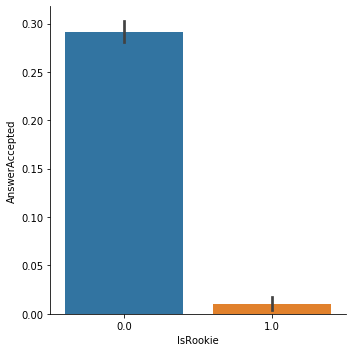

In [18]:
# Create binary column determining if question had an accepted answer
questions['AnswerAccepted'] = questions['AcceptedAnswerId'].notnull().astype(int)
print("Percentage of All Questions With Approved Answer: {:.1f}".format(questions['AnswerAccepted'].mean() * 100))
sns.catplot('IsRookie', 'AnswerAccepted', data=questions, kind='bar')

Unsurprisingly, we see that rookie users' questions have a very small frequency of approved answers. This may be due to their poor question structure, or perhaps they simply don't know that they are supposed to mark an accepted answer. They may also be looking for a quick answer to their problem and aren't interested in getting involved in the Stack Exchange community. Stack Exchange could encourage this sense of community by promoting the importance of marking answers to questions.
Let's continue, using the data for established users, to see which individual topics struggle to get accepted answers. We will focus on the more popular tags, rather than the fringe topics that are less likely to get answers anyway.

In [19]:
# First filter out rookies 
veteran_questions = questions[questions['IsRookie'] == 0].reset_index()
# Get a baseline of tag frequencies for all questions
veteran_tag_count = count_tags(veteran_questions, view_multiplier=False)

# Filter out rookies and answered questions
unanswered_Qs = veteran_questions[veteran_questions['AnswerAccepted']==0].reset_index()

# Get tag count for unanswered questions
unanswered_tag_count = count_tags(unanswered_Qs, view_multiplier=False)

# Make sure both dicts have matching keys
diff = set(veteran_tag_count) - set(unanswered_tag_count)
for key in diff:
    unanswered_tag_count[key] = 0

# Divide num unanswered question tags by total of all tags to get frequency
pct_unanswered = {tag: unanswered_tag_count[tag] / veteran_tag_count[tag] for tag in veteran_tag_count}

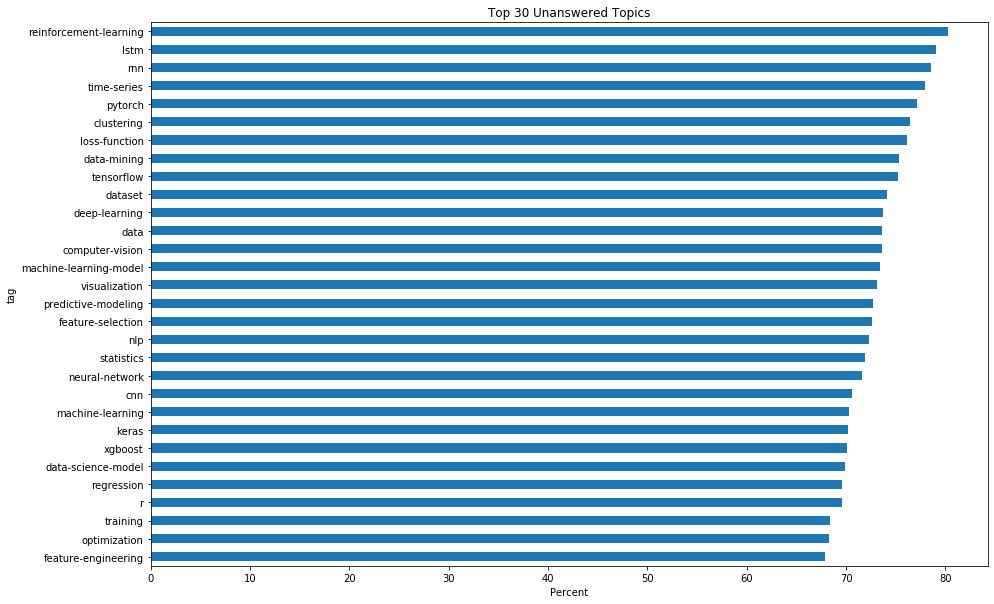

In [20]:
# Let's focus on the more popular tags, those with counts of more than 100
tag_count_over_100 = {tag: veteran_tag_count[tag] for tag in veteran_tag_count if veteran_tag_count[tag] > 100}
pct_unanswered_over_100 = {tag: pct_unanswered[tag] for tag in pct_unanswered if tag in tag_count_over_100}

# Find the top 30 tags and plot
top_30_tags = sorted(pct_unanswered_over_100.items(), key=lambda x: x[1])[-30:]
tags_df = pd.DataFrame(top_30_tags, columns = ['tag', 'percent'])
tags_df['percent'] = tags_df['percent'] * 100
tags_df.plot(kind='barh', x='tag',y = 'percent', legend=None, figsize=(15, 10))

plt.title("Top 30 Unanswered Topics")
plt.xlabel('Percent')
plt.show()

In [21]:
# Pull unanswered questions relating to reinforcement learning
unanswered_Qs[unanswered_Qs['Tags'].apply(lambda x: 'reinforcement-learning' in x)]['Title'].to_csv('reinforcement_learning_questions.csv')

This plot reveals the popular topics that are most likely to be unanswered. The vast majority are technical machine learning topics. We also see that R is among them while Python is not, indicating that it may be trickier to get solutions to R problems. R may be a language with limited resources that a curriculum could capitalize on, and machine learning topics in general still seem to have plenty of unsolved mysteries that could attract users.

# Recommendations
- New users 

    Give tips to new users upon sign up. Encourage them to write detailed questions (850 characters+). Also promote the idea of a community, and emphasize how important it is to mark questions as answered.
- Curriculum

    Heavily invest in machine learning curriculum. It is very popular and there are still plenty of open questions remaining. All of the unanswered questions regarding reinforcement learning (the most unanswered topic) have been attached for reference. Other unanswered questions are readily available. It is also recommend to have extensive deep learning coverage, but continue to monitor the trends closely to track demand. Also consider investing in R curriculum. Python instruction seems to be plentiful, but R is a popular topic with a high rate of unanswered questions.